# Token Cloud Centroid Analysis

**Goal:** Find the center of mass of the token cloud in eigenbasis coordinates.

**Motivation from 09.3g:**
- Individual dimension histograms showed peaks at different locations (not centered at origin)
- Rank 0: peak at +2.5 logometers
- Rank 2557: peak at +3 logometers
- Rank 2558: peak at 0 logometers
- Rank 2559: peak at -18 logometers

**Hypothesis:** The token cloud's center of mass is NOT at the origin in eigenbasis coordinates.

**Questions:**
1. Where is the centroid in eigenbasis coordinates?
2. How far is the centroid from the origin (in causal distance)?
3. Which eigenvector dimension dominates the centroid's position?

## Configuration

In [27]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

print(f"Configuration:")
print(f"  Projections: {PROJECTIONS_PATH}")
print(f"  Eigenbasis: {EIGENBASIS_PATH}")

Configuration:
  Projections: ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt
  Eigenbasis: ../data/vectors/eigenbasis_qwen3_4b.pt


## Setup

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Load Precomputed Data

In [29]:
print("Loading precomputed data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues']  # [hidden_dim]

# Load token projections
print(f"Loading token projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections']  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Projections shape: {projections.shape}")

Loading precomputed data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading token projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Projections shape: torch.Size([151936, 2560])


---

# Compute Centroid in Eigenbasis Coordinates

The centroid is the mean position of all tokens in eigenbasis space:

$$\text{centroid}_i = \frac{1}{V} \sum_{v=1}^V \text{proj}_{v,i}$$

where $V$ is vocab size (151,936) and $i$ ranges over eigenvector dimensions (0 to 2559).

In [30]:
print("\n" + "=" * 80)
print("COMPUTING CENTROID IN EIGENBASIS COORDINATES")
print("=" * 80)

# Compute centroid: mean projection along each eigenvector
centroid = projections.mean(dim=0)  # [hidden_dim]

print(f"\n✓ Centroid computed")
print(f"  Shape: {centroid.shape}")
print(f"\nCentroid statistics (in eigenbasis units):")
print(f"  Min component: {centroid.min().item():+.6f}")
print(f"  Max component: {centroid.max().item():+.6f}")
print(f"  Mean component: {centroid.mean().item():+.6f}")
print(f"  Std of components: {centroid.std().item():.6f}")


COMPUTING CENTROID IN EIGENBASIS COORDINATES

✓ Centroid computed
  Shape: torch.Size([2560])

Centroid statistics (in eigenbasis units):
  Min component: -0.068487
  Max component: +0.259548
  Mean component: +0.000094
  Std of components: 0.006024


## Visualize Centroid Components


Visualizing centroid components...



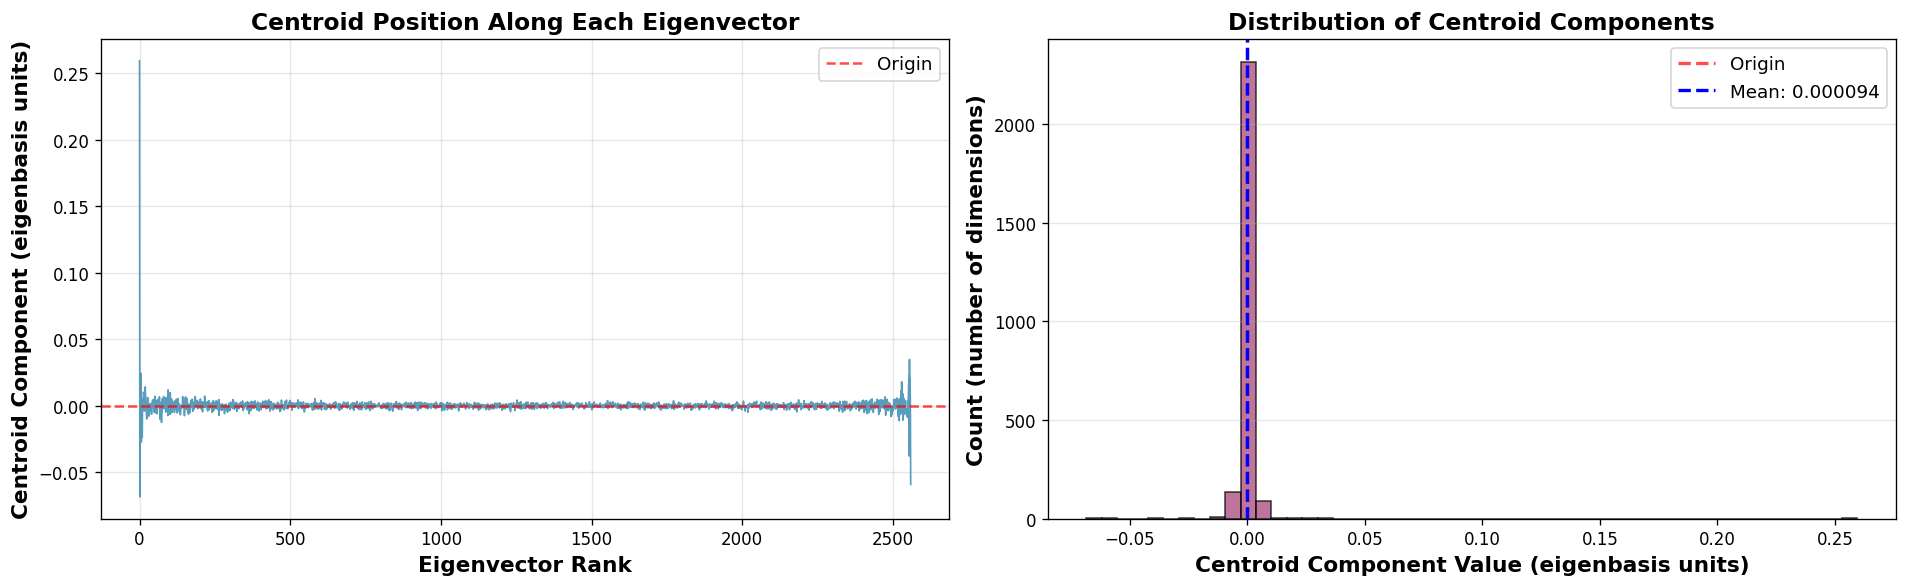

✓ Centroid component plots created


In [31]:
print("\nVisualizing centroid components...\n")

centroid_np = centroid.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=120)

# Plot 1: Centroid components vs eigenvector rank
ax1.plot(np.arange(hidden_dim), centroid_np, linewidth=1, color='#2E86AB', alpha=0.8)
ax1.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Origin')
ax1.set_xlabel('Eigenvector Rank', fontsize=13, fontweight='bold')
ax1.set_ylabel('Centroid Component (eigenbasis units)', fontsize=13, fontweight='bold')
ax1.set_title('Centroid Position Along Each Eigenvector',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of centroid components
ax2.hist(centroid_np, bins=50, color='#A23B72', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Origin')
ax2.axvline(centroid_np.mean(), color='blue', linestyle='--', linewidth=2,
            label=f'Mean: {centroid_np.mean():.6f}')
ax2.set_xlabel('Centroid Component Value (eigenbasis units)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Count (number of dimensions)', fontsize=13, fontweight='bold')
ax2.set_title('Distribution of Centroid Components',
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Centroid component plots created")

---

# Causal Distance from Origin to Centroid

To compute the causal distance, we need to:
1. Convert eigenbasis coordinates to causal distance units by scaling each component by $\sqrt{\lambda_i}$
2. Compute the norm: $d = \sqrt{\sum_i (\sqrt{\lambda_i} \cdot c_i)^2}$

where $c_i$ is the centroid component along eigenvector $i$.

In [32]:
print("\n" + "=" * 80)
print("CAUSAL DISTANCE FROM ORIGIN TO CENTROID")
print("=" * 80)

# Convert centroid to causal units
eigenvalues_np = eigenvalues.numpy()
scales = np.sqrt(eigenvalues_np)  # sqrt(λ_i) for each dimension

centroid_causal = scales * centroid_np  # Scale each component

# Compute causal distance (L2 norm in causal space)
distance_to_centroid = np.sqrt((centroid_causal ** 2).sum())

print(f"\n✓ Causal distance computed")
print(f"\n  Distance from origin to centroid: {distance_to_centroid:.4f} logometers")

# For context, what's the typical token distance from origin?
# We can approximate this using the data from 09.3g if we had it,
# but let's compute it fresh here
print(f"\n  (Computing typical token distance for comparison...)")

# Compute causal distances for all tokens (this is what we did in 09.3g)
signed_distances = scales[np.newaxis, :] * projections.numpy()  # [vocab, hidden_dim]
token_causal_norms = np.sqrt((signed_distances ** 2).sum(axis=1))  # [vocab]

mean_token_distance = token_causal_norms.mean()
median_token_distance = np.median(token_causal_norms)

print(f"  Mean token distance from origin: {mean_token_distance:.4f} logometers")
print(f"  Median token distance from origin: {median_token_distance:.4f} logometers")
print(f"\n  Centroid offset as % of typical token distance: {(distance_to_centroid / mean_token_distance * 100):.2f}%")


CAUSAL DISTANCE FROM ORIGIN TO CENTROID

✓ Causal distance computed

  Distance from origin to centroid: 20.9652 logometers

  (Computing typical token distance for comparison...)
  Mean token distance from origin: 54.1318 logometers
  Median token distance from origin: 55.2608 logometers

  Centroid offset as % of typical token distance: 38.73%


---

# Dominant Eigenvector Directions

Which eigenvector dimensions contribute most to the centroid's position?

We look at the **magnitude** of each centroid component in **causal units** (scaled by $\sqrt{\lambda_i}$).

In [33]:
print("\n" + "=" * 80)
print("DOMINANT EIGENVECTOR DIRECTIONS FOR CENTROID")
print("=" * 80)

# Compute contribution of each dimension (in causal units)
# This is just |centroid_causal[i]| for each i
contributions = np.abs(centroid_causal)

# Find top 10 dimensions by contribution
top_indices = np.argsort(contributions)[::-1][:10]  # Descending order, top 10

print(f"\nTop 10 eigenvector dimensions by centroid contribution:\n")
print(f"{'Rank':<8} {'Eigenvalue':<15} {'Centroid (eigenbasis)':<25} {'Contribution (causal)':<25} {'% of total'}")
print("=" * 100)

total_distance_sq = distance_to_centroid ** 2  # For percentage calculation

for rank in top_indices:
    eigenval = eigenvalues_np[rank]
    centroid_comp = centroid_np[rank]
    causal_comp = centroid_causal[rank]
    contribution = contributions[rank]
    
    # Percentage of total distance (contribution^2 / total^2)
    pct = (causal_comp ** 2) / total_distance_sq * 100
    
    print(f"{rank:<8} {eigenval:>14,.0f} {centroid_comp:>+24.6f} {causal_comp:>+24.6f} {pct:>11.2f}%")

print("\nNote: Contribution is in causal distance units (logometers)")
print("      Percentage shows how much each dimension contributes to total centroid displacement")


DOMINANT EIGENVECTOR DIRECTIONS FOR CENTROID

Top 10 eigenvector dimensions by centroid contribution:

Rank     Eigenvalue      Centroid (eigenbasis)     Contribution (causal)     % of total
2559             94,218                -0.059107               -18.142992       74.89%
2554             16,972                -0.037749                -4.917939        5.50%
2555             18,422                +0.034836                +4.728182        5.09%
2557             24,434                +0.020227                +3.161798        2.27%
2553             13,928                +0.022271                +2.628320        1.57%
0                    95                +0.259548                +2.534448        1.46%
2556             19,142                -0.013487                -1.865949        0.79%
2529              6,392                +0.018030                +1.441464        0.47%
2552             12,148                +0.013024                +1.435524        0.47%
1                   315  

## Visualize Causal Contributions


Visualizing causal contributions...



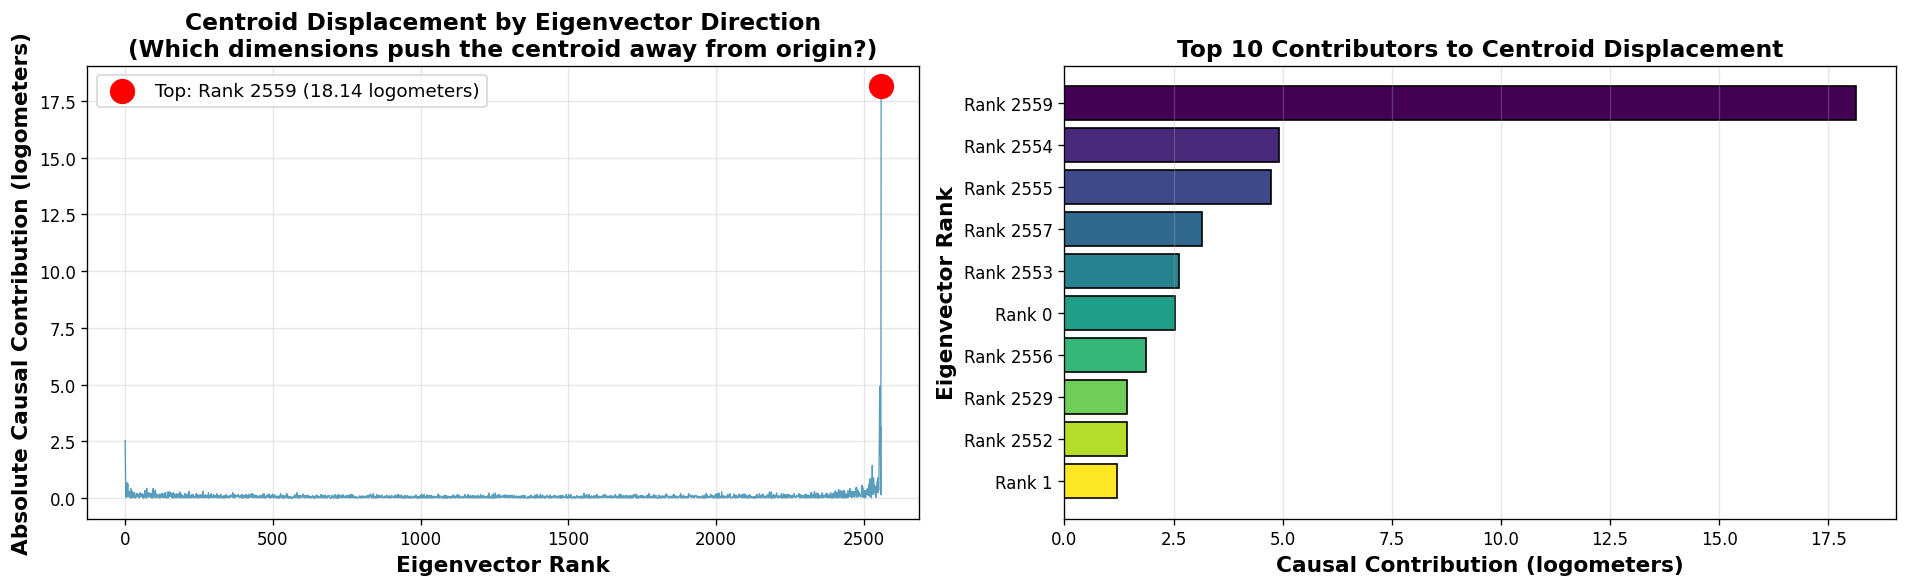

✓ Causal contribution plots created


In [34]:
print("\nVisualizing causal contributions...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=120)

# Plot 1: Causal contributions vs eigenvector rank
ax1.plot(np.arange(hidden_dim), contributions, linewidth=0.8, color='#2E86AB', alpha=0.8)

# Mark top contributor
top_rank = top_indices[0]
ax1.scatter([top_rank], [contributions[top_rank]], s=200, color='red', zorder=10,
           label=f'Top: Rank {top_rank} ({contributions[top_rank]:.2f} logometers)')

ax1.set_xlabel('Eigenvector Rank', fontsize=13, fontweight='bold')
ax1.set_ylabel('Absolute Causal Contribution (logometers)', fontsize=13, fontweight='bold')
ax1.set_title('Centroid Displacement by Eigenvector Direction\n(Which dimensions push the centroid away from origin?)',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Top 10 contributions as bar chart
top_10_ranks = top_indices[:10]
top_10_contributions = contributions[top_10_ranks]

colors = plt.cm.viridis(np.linspace(0, 1, 10))
ax2.barh(np.arange(10), top_10_contributions, color=colors, edgecolor='black')
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels([f'Rank {r}' for r in top_10_ranks])
ax2.invert_yaxis()  # Highest at top
ax2.set_xlabel('Causal Contribution (logometers)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Eigenvector Rank', fontsize=13, fontweight='bold')
ax2.set_title('Top 10 Contributors to Centroid Displacement',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✓ Causal contribution plots created")

---

# Pre-Flight Check: Raw Gamma Mean

**Key question:** Is the centroid offset a property of the raw token vectors, or an artifact of the eigenbasis transformation?

We'll load the raw unembedding matrix γ and check if it has a non-zero mean BEFORE any eigenbasis projection.

If mean(γ) ≠ 0, then **Option 1** is correct: vectors have inherent bias in original space  
If mean(γ) ≈ 0, then **Option 2** would be correct: metric transformation creates apparent offset

In [35]:
print("\n" + "=" * 80)
print("LOADING RAW GAMMA MATRIX (UNEMBEDDING WEIGHTS)")
print("=" * 80)

from transformers import AutoModelForCausalLM

MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

print(f"\nLoading model: {MODEL_NAME}")
print("  (We only need lm_head.weight, will delete model after)")

# Load model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float32,
    device_map='cpu'
)

# Extract gamma
gamma = model.lm_head.weight.data.clone()  # [vocab_size, hidden_dim]
print(f"\n✓ Gamma extracted")
print(f"  Shape: {gamma.shape}")

# Delete model to free memory
del model
import gc
gc.collect()
print(f"  Model deleted (memory freed)")

# Compute mean of gamma
gamma_mean = gamma.mean(dim=0)  # [hidden_dim] - mean token vector in original space
gamma_mean_norm = torch.norm(gamma_mean).item()

print(f"\n{'='*80}")
print("GAMMA MEAN ANALYSIS")
print(f"{'='*80}")

print(f"\nMean token vector (in original embedding space):")
print(f"  ||mean(γ)||₂ (Euclidean norm): {gamma_mean_norm:.6f}")
print(f"  Min component: {gamma_mean.min().item():+.6e}")
print(f"  Max component: {gamma_mean.max().item():+.6e}")
print(f"  Mean component: {gamma_mean.mean().item():+.6e}")
print(f"  Std of components: {gamma_mean.std().item():.6e}")

# Compare to typical token norm
token_norms = torch.norm(gamma, dim=1)
mean_token_norm = token_norms.mean().item()

print(f"\nComparison:")
print(f"  Mean token norm: {mean_token_norm:.6f}")
print(f"  Centroid norm: {gamma_mean_norm:.6f}")
print(f"  Centroid as % of mean token: {(gamma_mean_norm / mean_token_norm * 100):.2f}%")

if gamma_mean_norm > 0.01:  # Arbitrary threshold for "non-zero"
    print(f"\n✓ RESULT: Gamma has NON-ZERO mean in original space!")
    print(f"  → Option 1 is correct: vectors have inherent bias")
    print(f"  → The centroid offset exists BEFORE any metric transformation")
else:
    print(f"\n✓ RESULT: Gamma mean is essentially zero")
    print(f"  → Option 2 might be involved: metric creates apparent offset")
    
# Store gamma and gamma_mean for later use
print(f"\n  (Keeping gamma and gamma_mean for further analysis)")


LOADING RAW GAMMA MATRIX (UNEMBEDDING WEIGHTS)

Loading model: Qwen/Qwen3-4B-Instruct-2507
  (We only need lm_head.weight, will delete model after)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


✓ Gamma extracted
  Shape: torch.Size([151936, 2560])
  Model deleted (memory freed)

GAMMA MEAN ANALYSIS

Mean token vector (in original embedding space):
  ||mean(γ)||₂ (Euclidean norm): 0.304777
  Min component: -5.448563e-02
  Max component: +4.347062e-02
  Mean component: -2.642915e-05
  Std of components: 6.024804e-03

Comparison:
  Mean token norm: 1.087283
  Centroid norm: 0.304777
  Centroid as % of mean token: 28.03%

✓ RESULT: Gamma has NON-ZERO mean in original space!
  → Option 1 is correct: vectors have inherent bias
  → The centroid offset exists BEFORE any metric transformation

  (Keeping gamma and gamma_mean for further analysis)


## Relationship Between Gamma Mean and Eigenbasis Centroid

If gamma has non-zero mean, we should be able to **project that mean vector** onto the eigenbasis and recover the centroid we computed earlier.

Let's verify: `centroid_eigenbasis = gamma_mean @ eigenvectors`

This will prove whether the eigenbasis centroid is just the raw gamma mean rotated into a different coordinate system.

In [36]:
print("\n" + "=" * 80)
print("PROJECTING GAMMA MEAN ONTO EIGENBASIS")
print("=" * 80)

# Load eigenvectors
eigenvectors = eigenbasis_data['eigenvectors']  # [hidden_dim, hidden_dim]

print(f"\nProjecting mean(γ) onto eigenvectors...")

# Project gamma_mean onto eigenbasis
gamma_mean_projected = gamma_mean @ eigenvectors
gamma_mean_projected_np = gamma_mean_projected.numpy()

print(f"✓ Projection complete")
print(f"  Shape: {gamma_mean_projected.shape}")

# Compare to centroid computed from projections.mean()
print(f"\nComparison with eigenbasis centroid:\n")
print(f"{'Dimension':<12} {'Centroid (from projections)':<30} {'Mean(γ) projected':<30} {'Match?'}")
print("=" * 95)

# Check a few key dimensions
check_dims = [0, 1, 2557, 2558, 2559]
for dim in check_dims:
    centroid_val = centroid_np[dim]
    projected_val = gamma_mean_projected_np[dim]
    diff = abs(centroid_val - projected_val)
    match = "✓ YES" if diff < 1e-6 else f"✗ NO (diff: {diff:.2e})"
    
    print(f"{dim:<12} {centroid_val:>+29.6f} {projected_val:>+29.6f}   {match}")

# Overall comparison
max_diff = np.abs(centroid_np - gamma_mean_projected_np).max()
print(f"\nMax difference across all dimensions: {max_diff:.2e}")

if max_diff < 1e-5:
    print(f"\n✓ CONFIRMED: Eigenbasis centroid = mean(γ) rotated into eigenbasis")
    print(f"  → The centroid offset is purely a property of the raw token vectors")
    print(f"  → Eigenbasis just reveals WHERE that offset points")
else:
    print(f"\n⚠ WARNING: Centroids don't match perfectly!")
    print(f"  → Something unexpected is happening")


PROJECTING GAMMA MEAN ONTO EIGENBASIS

Projecting mean(γ) onto eigenvectors...
✓ Projection complete
  Shape: torch.Size([2560])

Comparison with eigenbasis centroid:

Dimension    Centroid (from projections)    Mean(γ) projected              Match?
0                                +0.259548                     +0.259548   ✓ YES
1                                -0.068487                     -0.068487   ✓ YES
2557                             +0.020227                     +0.020227   ✓ YES
2558                             -0.000526                     -0.000526   ✓ YES
2559                             -0.059107                     -0.059107   ✓ YES

Max difference across all dimensions: 1.77e-08

✓ CONFIRMED: Eigenbasis centroid = mean(γ) rotated into eigenbasis
  → The centroid offset is purely a property of the raw token vectors
  → Eigenbasis just reveals WHERE that offset points


## Verification: Centering Gamma Removes the Offset

If the offset is truly a uniform shift applied to all vectors, then subtracting `gamma_mean` from every token vector should center the cloud at the origin.

Let's verify:
1. Compute `gamma_centered = gamma - gamma_mean`
2. Check that `gamma_centered.mean() ≈ 0`
3. Project onto eigenbasis and verify centroid disappears

In [37]:
print("\n" + "=" * 80)
print("CENTERING GAMMA: REMOVING THE GLOBAL OFFSET")
print("=" * 80)

print("\nSubtracting gamma_mean from all token vectors...")

# Center gamma
gamma_centered = gamma - gamma_mean
print("✓ Gamma centered")

# Verify mean is now zero in Euclidean space
gamma_centered_mean = gamma_centered.mean(dim=0)
gamma_centered_mean_norm = torch.norm(gamma_centered_mean).item()

print(f"\nCentered gamma mean statistics:")
print(f"  ||mean(gamma_centered)||₂: {gamma_centered_mean_norm:.2e}")
print(f"  Max component: {gamma_centered_mean.abs().max().item():.2e}")

# Project centered gamma onto eigenbasis
print(f"\nProjecting centered vectors onto eigenbasis...")
gamma_centered_projected = gamma_centered @ eigenvectors
centroid_centered = gamma_centered_projected.mean(dim=0)
centroid_centered_np = centroid_centered.numpy()

print(f"✓ Projection complete")

# Check if centroid vanished
print(f"\nCentroid of centered cloud (eigenbasis coordinates):")
print(f"  Max component: {np.abs(centroid_centered_np).max():.2e}")
print(f"  Mean component: {np.abs(centroid_centered_np).mean():.2e}")

# Check specific dimensions that had large offsets
print(f"\nKey dimensions (previously offset):")
print(f"  Dimension 2559: {centroid_centered_np[2559]:+.2e} (was {centroid_np[2559]:+.6f})")
print(f"  Dimension 0:    {centroid_centered_np[0]:+.2e} (was {centroid_np[0]:+.6f})")
print(f"  Dimension 2554: {centroid_centered_np[2554]:+.2e} (was {centroid_np[2554]:+.6f})")

# Compute causal distance to verify it's zero
centroid_centered_causal = scales * centroid_centered_np
distance_centered = np.sqrt((centroid_centered_causal ** 2).sum())

print(f"\nCausal distance from origin to centered centroid:")
print(f"  Distance: {distance_centered:.2e} logometers (was {distance_to_centroid:.4f})")

if distance_centered < 1e-4:  # Generous threshold for floating-point errors
    print(f"\n✓ VERIFICATION SUCCESSFUL!")
    print(f"  → Subtracting gamma_mean eliminates the centroid offset")
    print(f"  → Residual distance ({distance_centered:.2e}) is just floating-point noise")
    print(f"  → The offset is a UNIFORM SHIFT applied to all token vectors")
    print(f"  → All 151,936 tokens share a common 'DC offset' in embedding space")
else:
    print(f"\n⚠ WARNING: Centroid didn't fully vanish!")
    print(f"  → Residual distance: {distance_centered:.6f} logometers")
    print(f"  → Something more complex is happening")


CENTERING GAMMA: REMOVING THE GLOBAL OFFSET

Subtracting gamma_mean from all token vectors...
✓ Gamma centered

Centered gamma mean statistics:
  ||mean(gamma_centered)||₂: 3.95e-08
  Max component: 1.17e-08

Projecting centered vectors onto eigenbasis...
✓ Projection complete

Centroid of centered cloud (eigenbasis coordinates):
  Max component: 4.49e-09
  Mean component: 5.01e-10

Key dimensions (previously offset):
  Dimension 2559: -1.33e-09 (was -0.059107)
  Dimension 0:    -4.12e-09 (was +0.259548)
  Dimension 2554: -1.88e-09 (was -0.037749)

Causal distance from origin to centered centroid:
  Distance: 1.86e-06 logometers (was 20.9652)

✓ VERIFICATION SUCCESSFUL!
  → Subtracting gamma_mean eliminates the centroid offset
  → Residual distance (1.86e-06) is just floating-point noise
  → The offset is a UNIFORM SHIFT applied to all token vectors
  → All 151,936 tokens share a common 'DC offset' in embedding space


---

# Interpreting Eigenvector 2559: What Does It Represent?

Dimension 2559 (largest eigenvalue) accounts for 75% of the centroid offset. What semantic property does this eigenvector capture?

Let's find the tokens that point most strongly along ±2559 and see if there's an interpretable pattern.

In [38]:
print("\n" + "=" * 80)
print("DIMENSION 2559: TOP TOKENS BY ALIGNMENT")
print("=" * 80)

from transformers import AutoTokenizer

# Load tokenizer to decode token IDs
print(f"\nLoading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✓ Tokenizer loaded")

# Get projections onto eigenvector 2559 (already computed in projections data)
dim_2559_projections = projections_np[:, 2559]  # [vocab_size]

# Compute cosine similarities (normalize by token norms in eigenbasis)
# For simplicity, we'll just use raw projections (higher = more aligned with +direction)

print(f"\nFinding tokens most aligned with eigenvector 2559...\n")

# Top 100 tokens in +2559 direction (most positive projections)
top_positive_indices = np.argsort(dim_2559_projections)[::-1][:100]
top_positive_projections = dim_2559_projections[top_positive_indices]

# Top 100 tokens in -2559 direction (most negative projections)
top_negative_indices = np.argsort(dim_2559_projections)[:100]
top_negative_projections = dim_2559_projections[top_negative_indices]

print("=" * 100)
print("TOP 30 TOKENS ALIGNED WITH +2559 DIRECTION")
print("=" * 100)
print(f"{'Rank':<6} {'Token ID':<10} {'Projection':<15} {'Token String'}")
print("=" * 100)

for rank, (idx, proj) in enumerate(zip(top_positive_indices[:30], top_positive_projections[:30]), 1):
    token_str = tokenizer.decode([idx])
    # Clean up token string for display
    token_display = repr(token_str)  # Show with quotes and escape sequences
    print(f"{rank:<6} {idx:<10} {proj:>+14.6f}   {token_display}")

print("\n" + "=" * 100)
print("TOP 30 TOKENS ALIGNED WITH -2559 DIRECTION")
print("=" * 100)
print(f"{'Rank':<6} {'Token ID':<10} {'Projection':<15} {'Token String'}")
print("=" * 100)

for rank, (idx, proj) in enumerate(zip(top_negative_indices[:30], top_negative_projections[:30]), 1):
    token_str = tokenizer.decode([idx])
    token_display = repr(token_str)
    print(f"{rank:<6} {idx:<10} {proj:>+14.6f}   {token_display}")

print("\n" + "=" * 80)
print("ANALYSIS QUESTIONS:")
print("=" * 80)
print("  - Do the +2559 tokens share a semantic pattern?")
print("  - Do the -2559 tokens share a different pattern?")
print("  - Is there a clear interpretable axis (e.g., size, sentiment, formality)?")
print("  - Or is this dimension capturing something more abstract?")


DIMENSION 2559: TOP TOKENS BY ALIGNMENT

Loading tokenizer for Qwen/Qwen3-4B-Instruct-2507...
✓ Tokenizer loaded

Finding tokens most aligned with eigenvector 2559...

TOP 30 TOKENS ALIGNED WITH +2559 DIRECTION
Rank   Token ID   Projection      Token String
1      151643          -0.018807   '<|endoftext|>'
2      50950           -0.032929   '\xa0\n'
3      44993           -0.034625   '….\n\n'
4      118276          -0.036584   '該使用者'
5      98018           -0.037134   '-Cds'
6      4102            -0.037234   '\xa0'
7      23086           -0.038459   ' [-]:'
8      56622           -0.038895   ' ;;='
9      128337          -0.039377   'nın'
10     18987           -0.039547   ' ”'
11     151663          -0.040058   '<|repo_name|>'
12     71916           -0.040082   ' EnumerableStream'
13     150130          -0.040379   '↛'
14     114323          -0.040526   '當您在'
15     63028           -0.041073   '":[-'
16     28038           -0.041611   ' )\n\n\n\n\n\n\n\n'
17     146942          -0.

---

# Angular Bias: Mean Signed Cosine per Dimension

**Alternative framing:** The centroid components tell us the **mean signed position** along each eigenvector.

We can think of this as an **angular bias**:
- Positive mean → tokens biased toward pointing **along** (+) the eigenvector
- Negative mean → tokens biased toward pointing **against** (−) the eigenvector  
- Zero mean → tokens symmetric/balanced around origin

For dimension 2559 with centroid component −0.059:
- This means on average, tokens point in the **−2559 direction**
- If we "look" in the +2559 direction, most tokens are "behind us"

Let's visualize this as **mean signed cosine similarity** for each dimension.

In [39]:
print("\n" + "=" * 80)
print("ANGULAR BIAS: MEAN SIGNED PROJECTION PER DIMENSION")
print("=" * 80)

# The centroid components ARE the mean signed projections
# But let's also compute the mean SIGNED COSINE for intuition

print("\nComputing mean signed cosine similarity for each dimension...\n")

# For each dimension, compute cosine similarity = proj_i / ||token||
# We'll use the causal norm for ||token||
# (Already computed as token_causal_norms in earlier cell)

projections_np = projections.numpy()

# Compute signed cosines for each dimension
mean_signed_cosines = np.zeros(hidden_dim)

for i in range(hidden_dim):
    # Signed cosine = projection_i / causal_norm
    # projection_i is in eigenbasis units, need to scale by sqrt(lambda_i)
    signed_proj_causal = scales[i] * projections_np[:, i]
    
    # Cosine = component / total_norm
    cosines = signed_proj_causal / token_causal_norms
    
    # Mean signed cosine
    mean_signed_cosines[i] = cosines.mean()

print(f"✓ Mean signed cosines computed\n")

# Summary stats
print(f"Mean signed cosine statistics:")
print(f"  Min: {mean_signed_cosines.min():+.6f}")
print(f"  Max: {mean_signed_cosines.max():+.6f}")
print(f"  Mean: {mean_signed_cosines.mean():+.6f}")
print(f"  Std: {mean_signed_cosines.std():.6f}")

# Find dimensions with strongest bias
abs_mean_cosines = np.abs(mean_signed_cosines)
top_bias_indices = np.argsort(abs_mean_cosines)[::-1][:5]

print(f"\nTop 5 dimensions by angular bias:\n")
print(f"{'Rank':<8} {'Eigenvalue':<15} {'Mean Signed Cosine':<25} {'Interpretation'}")
print("=" * 80)

for rank in top_bias_indices:
    eigenval = eigenvalues_np[rank]
    mean_cos = mean_signed_cosines[rank]
    
    if mean_cos > 0:
        interpretation = "Tokens point ALONG + direction"
    else:
        interpretation = "Tokens point AGAINST + direction (toward −)"
    
    print(f"{rank:<8} {eigenval:>14,.0f} {mean_cos:>+24.6f}   {interpretation}")


ANGULAR BIAS: MEAN SIGNED PROJECTION PER DIMENSION

Computing mean signed cosine similarity for each dimension...

✓ Mean signed cosines computed

Mean signed cosine statistics:
  Min: -0.346765
  Max: +0.090271
  Mean: -0.000065
  Std: 0.007926

Top 5 dimensions by angular bias:

Rank     Eigenvalue      Mean Signed Cosine        Interpretation
2559             94,218                -0.346765   Tokens point AGAINST + direction (toward −)
2554             16,972                -0.094224   Tokens point AGAINST + direction (toward −)
2555             18,422                +0.090271   Tokens point ALONG + direction
2557             24,434                +0.060694   Tokens point ALONG + direction
2553             13,928                +0.050206   Tokens point ALONG + direction


## Visualize Angular Bias Across All Dimensions


Visualizing angular bias...



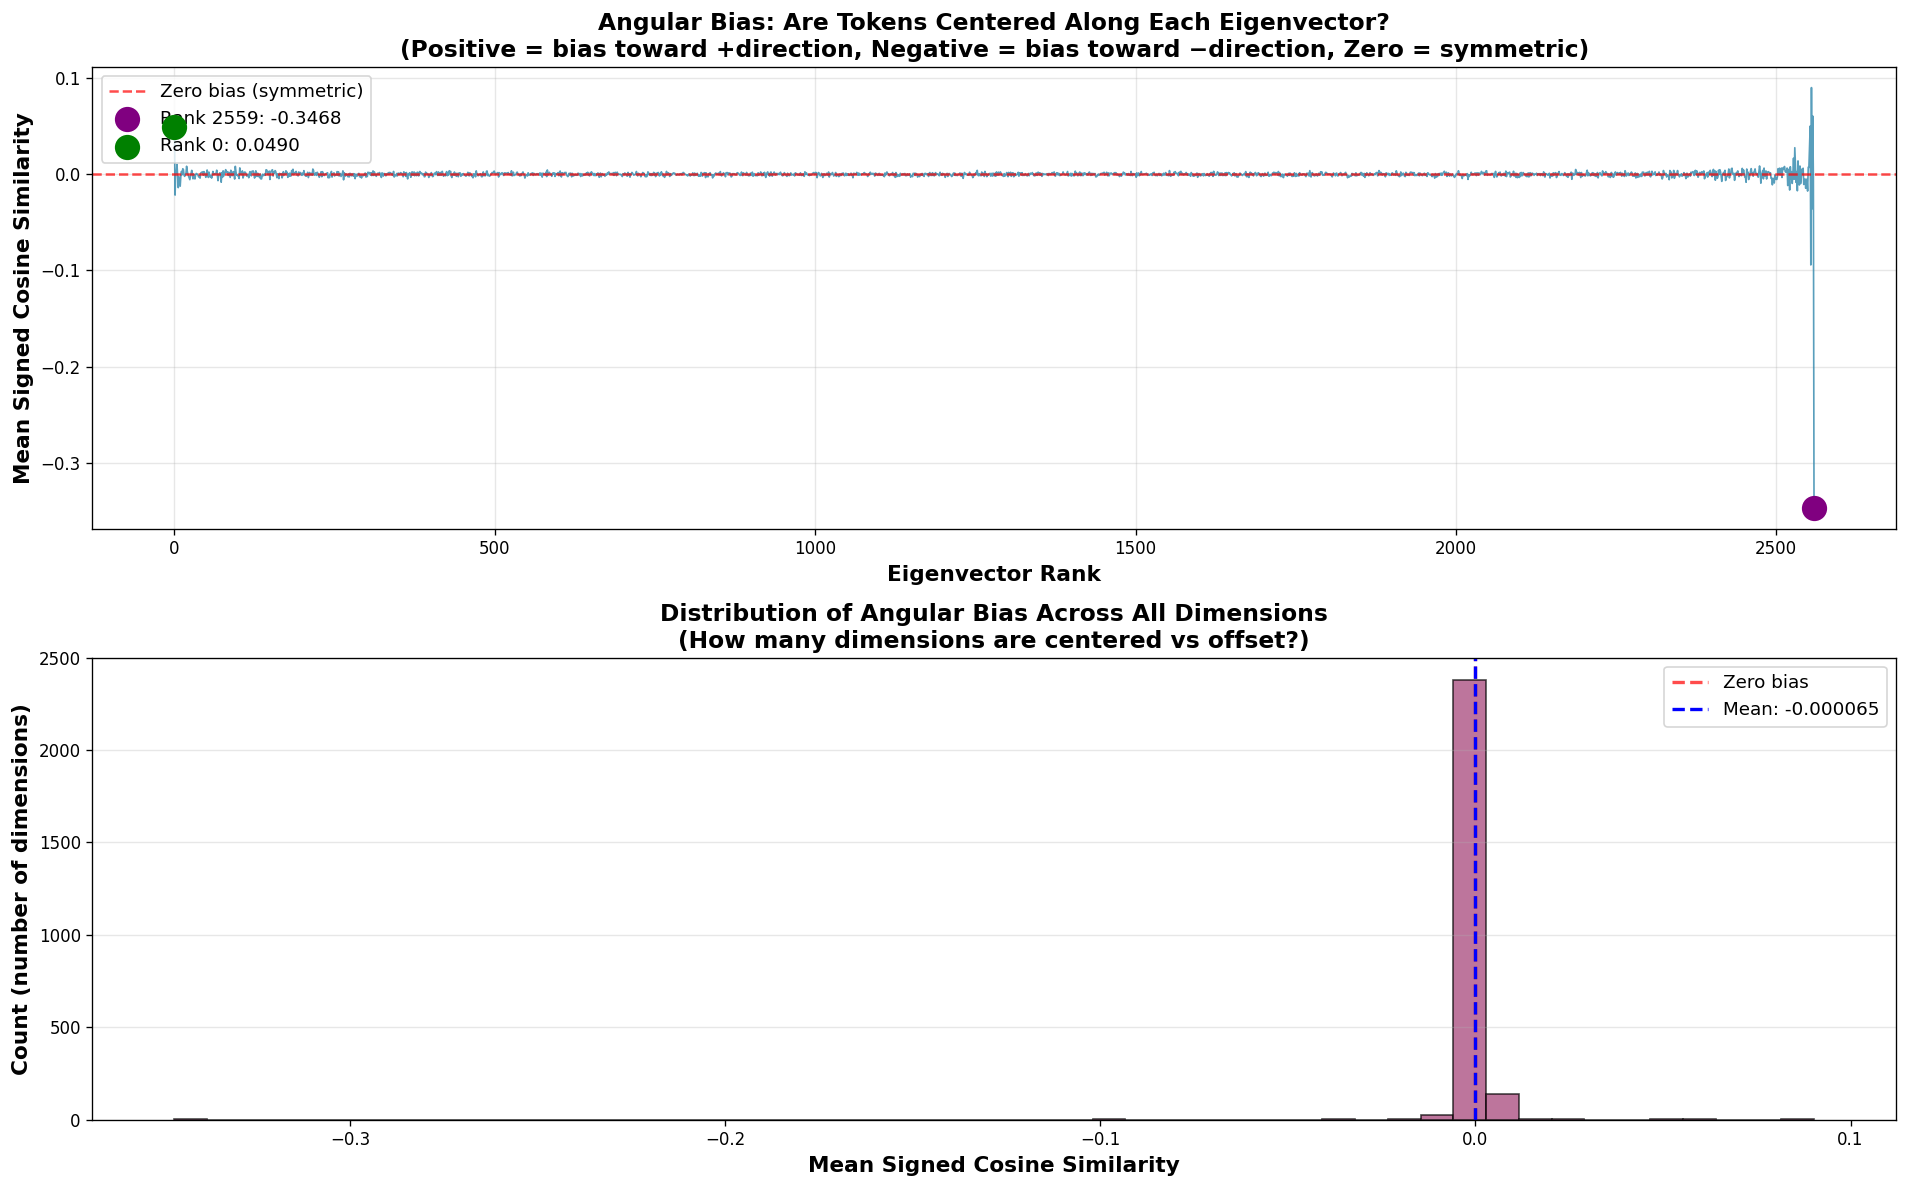

✓ Angular bias plots created

Dimensions with |mean cosine| < 0.001: 1204 / 2560 (47.0%)
Dimensions with noticeable bias: 1356 (53.0%)


In [40]:
print("\nVisualizing angular bias...\n")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), dpi=120)

# Plot 1: Mean signed cosine vs eigenvector rank
ax1.plot(np.arange(hidden_dim), mean_signed_cosines, 
         linewidth=1, color='#2E86AB', alpha=0.8)
ax1.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
            label='Zero bias (symmetric)')

# Mark dimension 2559
ax1.scatter([2559], [mean_signed_cosines[2559]], s=200, color='purple', 
            zorder=10, label=f'Rank 2559: {mean_signed_cosines[2559]:.4f}')

# Mark dimension 0
ax1.scatter([0], [mean_signed_cosines[0]], s=200, color='green',
            zorder=10, label=f'Rank 0: {mean_signed_cosines[0]:.4f}')

ax1.set_xlabel('Eigenvector Rank', fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean Signed Cosine Similarity', fontsize=13, fontweight='bold')
ax1.set_title('Angular Bias: Are Tokens Centered Along Each Eigenvector?\n' +
              '(Positive = bias toward +direction, Negative = bias toward −direction, Zero = symmetric)',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of mean signed cosines
ax2.hist(mean_signed_cosines, bins=50, color='#A23B72', alpha=0.7, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero bias')
ax2.axvline(mean_signed_cosines.mean(), color='blue', linestyle='--', linewidth=2,
            label=f'Mean: {mean_signed_cosines.mean():.6f}')
ax2.set_xlabel('Mean Signed Cosine Similarity', fontsize=13, fontweight='bold')
ax2.set_ylabel('Count (number of dimensions)', fontsize=13, fontweight='bold')
ax2.set_title('Distribution of Angular Bias Across All Dimensions\n' +
              '(How many dimensions are centered vs offset?)',
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Angular bias plots created")

# Count how many dimensions are "centered" (within some threshold)
threshold = 0.001  # Pretty tight threshold
n_centered = np.sum(np.abs(mean_signed_cosines) < threshold)
pct_centered = n_centered / hidden_dim * 100

print(f"\nDimensions with |mean cosine| < {threshold}: {n_centered} / {hidden_dim} ({pct_centered:.1f}%)")
print(f"Dimensions with noticeable bias: {hidden_dim - n_centered} ({100 - pct_centered:.1f}%)")

---

# Summary

**What we measured:**
1. Centroid of token cloud in eigenbasis coordinates
2. Causal distance from origin to centroid (20.97 logometers)
3. Which eigenvector directions dominate the centroid's position (dimension 2559: 75%)
4. Angular bias: mean signed cosine per dimension (are tokens centered?)

**Key findings:**
- Centroid is 21 logometers from origin (39% of typical token distance)
- 75% of offset is in the −dimension 2559 direction
- Most dimensions have near-zero angular bias (tokens centered)
- A few dimensions (especially high-eigenvalue ones) show strong bias

**Interpretation:**
- Token cloud center is **significantly offset** from eigenbasis origin
- This explains why 09.3g showed peaks at different locations per dimension
- The offset is **highly concentrated** in dimension 2559 (largest eigenvalue)
- Most tokens point in the −2559 direction ("behind us" when looking +2559)

**Next steps:**
- Re-center projections relative to centroid (subtract centroid from all tokens)
- Re-compute signed distance plots to see if shell structure appears when centered properly
- Investigate WHY dimension 2559 has this massive bias (what does it represent?)